<img align="center" src="img/course.png" width="800">

# 16720 (B)  Object Tracking in Videos - Assignment 6 - Q1
    Instructor: Kris                          TAs: Arka, Rohan, Rawal, Sheng-Yu, Jinkun


In [ ]:
# Libraries

import numpy as np
from scipy.interpolate import RectBivariateSpline
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline

## Q1: Lucas-Kanade Forward Additive Alignment for Tracking

### Overview
In this part, you will implement two variants of the Lucas-Kanade Tracking algorithm:

- The warp $W$ being translation only
- The warp $W$ being the full affine transformation

and evaluate them on the provided videos, which can be downloaded [here](https://www.dropbox.com/sh/l2ip26mkgf5p3e6/AACN2STT5Sk9r6bPeEXIYKZCa?dl=0). It is highly recommended that you finish the theory section first, or at the very least, go over the provided materials to gain a better understanding of the algorithms. You may also find these materials useful: [link](https://www.ri.cmu.edu/pub_files/pub3/baker_simon_2002_3/baker_simon_2002_3.pdf) and [link](https://www.ri.cmu.edu/pub_files/pub3/baker_simon_2003_3/baker_simon_2003_3.pdf).


### Q1.1:  Lucas-Kanade Forward Additive Alignment with Translation Only (10 PT write-up, 20 PT implementation)
Write the function with the following function signature:

```
            p = LucasKanade(It, It1, rect, thresh, maxIt)
```
that computes the optimal local motion $p$ represented by translation (motion in x and y directions) from frame $I_t$ to frame $I_{t+1}$that minimizes

$$
\begin{gathered}
\mathcal{L}=\sum_{\mathbf{x}}[\mathbf{T}(\mathbf{x})-\mathbf{I}(\mathbf{W}(\mathbf{x} ; \mathbf{p}))]^{2}. 
\end{gathered}
$$

"It" is the image frame $I_t$, "It1" is the image frame $I_{t+1}$, and "rect" is a $4×1$ vector that represents a rectangle (bounding box) on the image frame $I_t$. The four elements of the rectangle are $[x1, y1, x2, y2]$, where $(x1, y1)$ is the top-left corner and $(x2, y2)$ is the bottom-right corner of the bounding box. "thresh" and "maxIt" control when the algorithm should stop, depending on if dp is too small or the maximum number of iterations has been reached, respectively.

Hints:
- To deal with the fractional movement of the template in the bounding box, you will need to interpolate the image using scipy.interpolate.RectBivariateSpline. The same function can also be used to compute the gradient of an image at a point location.
- You will need to iterate the estimation in Equation 10 until the change in warp parameters $(dx, dy)$ is below a threshold or the number of iterations is too large.
- You can use np.linalg.lstsq to solve the least square problem in Equation 10.

<span style='color:red'>**Output:**</span> In your write-up: Please include the results of the algorithm on all five videos we have provided along with your code.

In [ ]:
def LucasKanade(It, It1, rect, thresh=.025, maxIt=100):
    
    '''
    Q1.1: Lucas-Kanade Forward Additive Alignment with Translation Only
    
      Inputs: 
        It: template image
        It1: Current image
        rect: Current position of the object
        (top left, bottom right coordinates, x1, y1, x2, y2)
        thresh: Stop condition when dp is too small
        maxIt: Maximum number of iterations to run
        
      Outputs:
        p: movement vector dx, dy
    '''

    # Set thresholds (you probably want to play around with the values)
    p = np.zeros(2) # dx, dy
    i = 0
    x1, y1, x2, y2 = rect
    
    # Set the delta parameter value   
    dp                 = np.inf
    y_vals             = np.arange(0, It.shape[0])
    x_vals             = np.arange(0, It.shape[1])
    interp_spline_temp = RectBivariateSpline(x = y_vals, y = x_vals, z = It)
    y_vals             = np.arange(0, It1.shape[0])
    x_vals             = np.arange(0, It1.shape[1])
    interp_spline_curr = RectBivariateSpline(x = y_vals, y = x_vals, z = It1)
    
    # Get the template
    num_x = int(x2-x1)//2
    num_y = int(y2-y1)//2
    x = np.linspace(x1, x2, num_x)
    y = np.linspace(y1, y2, num_y)
    xv, yv= np.meshgrid(x, y) # Pairs of points for x and y
    T_x = interp_spline_temp.ev(yv, xv)
    #T_x = T_x.T
    while np.sum(dp**2) > thresh and i <= maxIt:

      # 1. Warp the current position of the object via the parameters
      p1_w   = np.array([x1, y1]) + p
      p2_w   = np.array([x2, y2]) + p

      # 2. Calculate the error image

      # Find the points we want to use
      x_w    = np.linspace(p1_w[0], p2_w[0], num_x)
      y_w    = np.linspace(p1_w[1], p2_w[1], num_y)
      xv, yv = np.meshgrid(x_w, y_w)
      I_w_x = interp_spline_curr.ev(yv, xv)
      # I_w_x = I_w_x.T
      
      # Find a by finding the image derivative of each pixel
      I_x = interp_spline_curr.ev(yv, xv, dx = 0, dy = 1) # Have to invert x and y for dy and dx
      I_y = interp_spline_curr.ev(yv, xv, dx = 1, dy = 0) # Have to invert x and y for dy and dx
      #I_x = I_x.T
      #I_y = I_y.T

      # Find the A matrix, transpose it to make it of size [m, 2]
      A = np.stack((I_x.reshape(-1), I_y.reshape(-1))).T

      # This is b [m, 1]
      I_t = T_x - I_w_x

      # Compute linear least squares
      #dp, residuals, rank, s = np.linalg.lstsq(A.T, I_t.reshape(-1), rcond = None)
      dp = np.linalg.inv(A.T @ A) @ A.T @ I_t.flatten()

      # Update p and find the parameter difference
      p += dp

      # Increment the iteration count
      i += 1

    return p

TypeError: only size-1 arrays can be converted to Python scalars

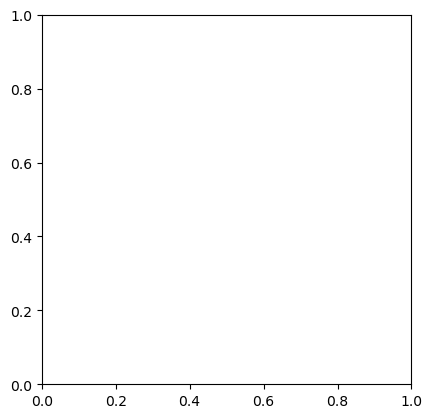

In [15]:
# Test your algorithm and visualize results!
import os

data_names = ["car1", "car2", "landing", "race", "ballet"]

# Load data
data_name = 'landing' # could choose from (car1, car2, landing, race, ballet)
for data_name in data_names:
    data = np.load('./data/%s.npy' % data_name)

    # obtain the initial rect with format (x1, y1, x2, y2)
    if data_name == 'car1':
        initial = np.array([170, 130, 290, 250])
    elif data_name == 'car2':
        initial = np.array([59, 116, 145, 151])
    elif data_name == 'landing':
        initial = np.array([440, 80, 560, 140])
    elif data_name == 'race':
        initial = np.array([170, 270, 300, 370])
    elif data_name == 'ballet':
        initial = np.array([700, 210, 775, 300])
    else:
        assert False, 'the data name must be one of (car1, car2, landing, race, ballet)'

    numFrames = data.shape[2]
    w = initial[2] - initial[0]
    h = initial[3] - initial[1]

    # loop over frames
    rects = []
    rects.append(initial)

    out_folder = f"results/q1.1/{data_name}/"
    if not os.path.exists(out_folder):
        os.mkdir(out_folder)

    for i in range(numFrames-1):

        It = data[:,:,i]
        It1 = data[:,:,i+1]
        rect = rects[i]

        # run algorithm and collect rects
        dx, dy = LucasKanade(It, It1, rect)
        newRect = np.array([rect[0] + dx, rect[1] + dy, rect[0] + dx + w, rect[1] + dy + h])
        rects.append(newRect)

        # Visualize
        fig = plt.figure(1)
        ax = fig.add_subplot(111)
        ax.add_patch(patches.Rectangle((rect[0], rect[1]), rect[2]-rect[0]+1, rect[3]-rect[1]+1, linewidth=2, edgecolor='red', fill=False))
        plt.imshow(It1, cmap='gray')
        if i%5 == 0:
            plt.savefig(out_folder + f"{i}.png")
        # plt.show()
        ax.clear()

In [ ]:
# For some transparency: we evaluate on multiple frames in a given video starting from the first frame.
# We then compare against the reference implementation and calculate the sum of all differences.
# You should not need to tune anything for the autograding. We pass in the same hyperparameters for you.


### Q1.2:  Lucas-Kanade Forward Additive Alignment with Affine Transformation (10 PT write-up, 20 PT implementation)
Assuming that the warp is translation-only is quite limiting. Now we will assume that the warp takes on the form of an arbitrary affine transformation. Write the function with the following function signature:

```
            M = LucasKanadeAffine(It, It1, rect):
```
that computes the optimal local motion represented by a $2x3$ affine transformation matrix $M$ from frame $I_t$ to frame $I_{t+1}$that minimizes

$$
\begin{gathered}
\mathcal{L}=\sum_{\mathbf{x}}[\mathbf{T}(\mathbf{x})-\mathbf{I}(\mathbf{W}(\mathbf{x} ; \mathbf{p}))]^{2}. 
\end{gathered}
$$

The inputs are structured identically to the previous problem.

<span style='color:red'>**Output:**</span> In your write-up: Please include the results of the algorithm on all five videos we have provided along with your code.

In [28]:
def LucasKanadeAffine(It, It1, rect, thresh=.025, maxIt=100):
    '''
    Q1.2: Lucas-Kanade Forward Additive Alignment with Affine MAtrix
    
      Inputs: 
        It: template image
        It1: Current image
        rect: Current position of the object
        (top left, bottom right coordinates, x1, y1, x2, y2)
        thresh: Stop condition when dp is too small
        maxIt: Maximum number of iterations to run
        
      Outputs:
        M: Affine mtarix (2x3)
    '''

    # Set thresholds (you probably want to play around with the values)
    M = np.array([[1.,0,0], [0,1.,0]])
    threshold = thresh
    maxIters = maxIt
    i = 0
    x1, y1, x2, y2 = rect
    dp = np.inf

    # Size of image
    x_img1 = np.arange(It1.shape[1])
    y_img1 = np.arange(It1.shape[0])

    # For calculating the template
    num_x = np.abs(int(x2-x1)//2)
    num_y = np.abs(int(y2-y1)//2)
    x = np.linspace(x1, x2, num_x)
    y = np.linspace(y1, y2, num_y)
    x_vals, y_vals = np.meshgrid(x, y)
    interp_spline_It = RectBivariateSpline(x = y_img1, y = x_img1, z = It)
    T_x = interp_spline_It.ev(y_vals, x_vals)

    # For calculating the interpolation of the next image
    interp_spline_It1 = RectBivariateSpline(x = y_img1, y = x_img1, z = It1)

    while np.sum(dp**2) >= threshold and i < maxIters:
      # Warp I with W(x;p)
      p1_w = M @ np.array([x1, y1, 1])
      p2_w = M @ np.array([x2, y2, 1])

      # 2. Find the the image pixels at the warped location
      x_warp = np.linspace(p1_w[0], p2_w[0], num_x)
      y_warp = np.linspace(p1_w[1], p2_w[1], num_y)
      x_vals_warp, y_vals_warp = np.meshgrid(x_warp, y_warp)
      I_w_x = interp_spline_It1.ev(y_vals_warp, x_vals_warp)

      # 3. Compute the error image
      I_t = T_x - I_w_x
      I_t = I_t.flatten()

      # 4. Compute the image gradient for I
      I_x = interp_spline_It1.ev(y_vals_warp, x_vals_warp, dx = 0, dy = 1)
      I_y = interp_spline_It1.ev(y_vals_warp, x_vals_warp, dx = 1, dy = 0)

      # Step 5-6, find the jacobian and steepest descent image, J/A
      # A1 =  x_vals.flatten() * I_x
      # A2 =  y_vals.flatten() * I_x
      # A4 = x_vals.flatten() * I_y
      # A5 = y_vals.flatten() * I_y
      # A  = np.vstack((A1, A2, I_x, A4, A5, I_y)).T
      A1 = (x_vals * I_x).flatten()
      A2 = (y_vals * I_x).flatten()
      A4 = (x_vals * I_y).flatten()
      A5 = (y_vals * I_y).flatten()
      A  = np.vstack((A1, A2, I_x.flatten(), A4, A5, I_y.flatten())).T
      
      # Try this instead of leastsq?? We need psuedo inverse instead of inverse because of the size
      # Steps 7-8 Calculate H and deltap
      H  = A.T @ A
      dp = np.linalg.inv(H) @ A.T @ I_t

      # 9. Update the parameters
      M += dp.reshape(2,3)
      i+=1

    return M

C:\Users\chris\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:68: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


LinAlgError: Singular matrix

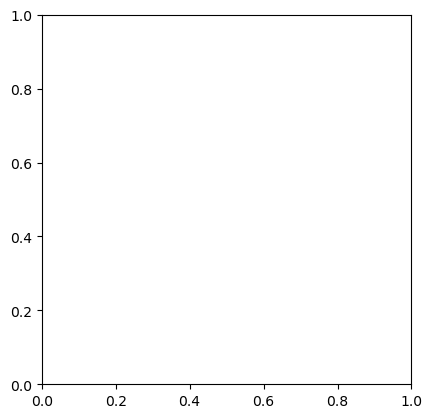

In [31]:
# Test your algorithm and visualize results!

# Load data
# data_name = 'landing' # could choose from (car1, car2, landing, race, ballet)
# data = np.load('./data/%s.npy' % data_name)
# Test your algorithm and visualize results!
import os

data_names = ["ballet"]

# Load data
data_name = 'landing' # could choose from (car1, car2, landing, race, ballet)
for data_name in data_names:
    data = np.load('./data/%s.npy' % data_name)

    # obtain the initial rect with format (x1, y1, x2, y2)
    if data_name == 'car1':
        initial = np.array([170, 130, 290, 250])   
    elif data_name == 'car2':
        initial = np.array([59, 116, 145, 151])    
    elif data_name == 'landing':
        initial = np.array([440, 80, 560, 140])     
    elif data_name == 'race':
        initial = np.array([170, 270, 300, 370])
    elif data_name == 'ballet':
        initial = np.array([700, 210, 775, 300])     
    else:
        assert False, 'the data name must be one of (car1, car2, landing, race, ballet)'

    if data_name == "car2":
        thresh = 0.75
        iter = 10
    elif data_name == "ballet":
        thresh = 0.001
        iter = 1000
    else:
        thresh = 0.025
        iter = 100

    numFrames = data.shape[2]
    w = initial[2] - initial[0]
    h = initial[3] - initial[1]

    # loop over frames
    rects = []
    rects.append(initial)


    out_folder = f"results/q1.2/{data_name}/"
    if not os.path.exists(out_folder):
        os.mkdir(out_folder)

    for i in range(numFrames-1):

        It = data[:,:,i]
        It1 = data[:,:,i+1]
        rect = rects[i]

        # run algorithm and collect rects
        M = LucasKanadeAffine(It, It1, rect, thresh=thresh, maxIt=iter)
        corners = np.array([[rect[0], rect[1], 1], 
                            [rect[2], rect[3], 1]]).transpose()
        newRect = np.matmul(M, corners).transpose().reshape((4, ))
        rects.append(newRect)

        # Visualize
        fig = plt.figure(1)
        ax = fig.add_subplot(111)
        ax.add_patch(patches.Rectangle((rect[0], rect[1]), rect[2]-rect[0]+1, rect[3]-rect[1]+1, linewidth=2, edgecolor='red', fill=False))
        plt.imshow(It1, cmap='gray')
        if i%5 == 0:
            plt.savefig(out_folder + f"{i}.png")
        #plt.show()
        ax.clear()


In [ ]:
# For some transparency: we evaluate on multiple frames in a given video starting from the first frame.
# We then compare against the reference implementation and calculate the sum of all differences.
# You should not need to tune anything for the autograding. We pass in the same hyperparameters for you.
